[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
63/63 - 19s - 295ms/step - loss: 0.0053
Epoch 2/20
63/63 - 11s - 171ms/step - loss: 9.8600e-04
Epoch 3/20
63/63 - 19s - 306ms/step - loss: 0.0011
Epoch 4/20
63/63 - 11s - 177ms/step - loss: 0.0011
Epoch 5/20
63/63 - 21s - 327ms/step - loss: 0.0011
Epoch 6/20
63/63 - 21s - 336ms/step - loss: 9.6474e-04
Epoch 7/20
63/63 - 19s - 306ms/step - loss: 7.8947e-04
Epoch 8/20
63/63 - 11s - 171ms/step - loss: 0.0011
Epoch 9/20
63/63 - 21s - 326ms/step - loss: 9.0500e-04
Epoch 10/20
63/63 - 20s - 311ms/step - loss: 7.2639e-04
Epoch 11/20
63/63 - 10s - 166ms/step - loss: 7.9250e-04
Epoch 12/20
63/63 - 11s - 171ms/step - loss: 5.9697e-04
Epoch 13/20
63/63 - 11s - 171ms/step - loss: 7.4952e-04
Epoch 14/20
63/63 - 20s - 324ms/step - loss: 7.2968e-04
Epoch 15/20
63/63 - 20s - 316ms/step - loss: 6.9280e-04
Epoch 16/20
63/63 - 11s - 169ms/step - loss: 7.0467e-04
Epoch 17/20
63/63 - 21s - 329ms/step - loss: 7.3546e-04
Epoch 18/20
63/63 - 20s - 313ms/step - loss: 6.2129e-04
Epoch 19/20
63/63 - 1

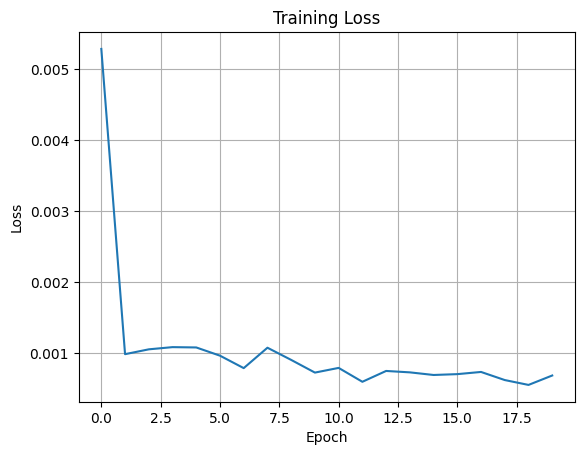

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


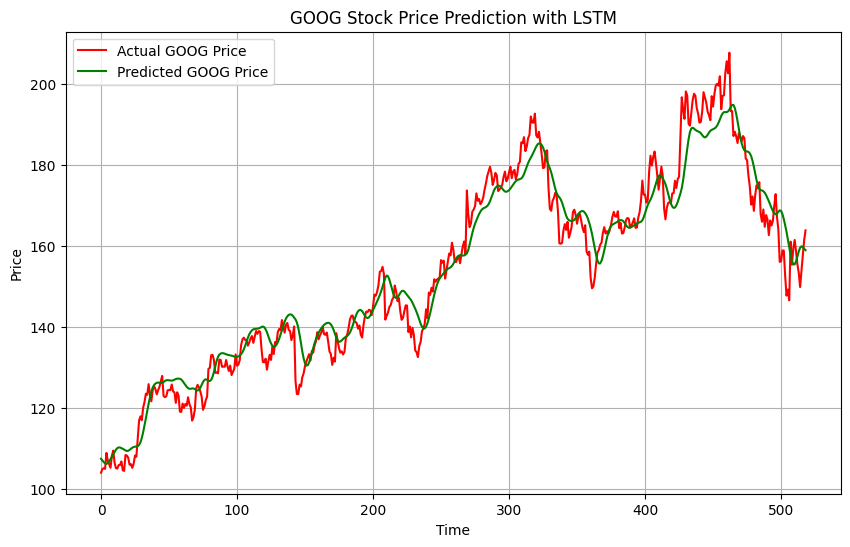

In [1]:
# Install required libraries (only if not already installed)
# !pip install yfinance tensorflow scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Step 1: Download data with adjusted close prices
data = yf.download('GOOG', start='2015-01-01', auto_adjust=False)
data.reset_index(inplace=True)

# Step 2: Preprocessing
# Use only the 'Close' column
close_data = data["Close"].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Split into training and test sets (80% training)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]  # last 60 for timestep continuity

# Step 3: Create training sequences
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Step 4: Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Step 6: Prepare test sequences
X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 7: Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Actual prices for comparison
actual_prices = scaler.inverse_transform(test_data[60:])

# Step 8: Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual GOOG Price')
plt.plot(predicted_prices, color='green', label='Predicted GOOG Price')
plt.title('GOOG Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
